# 1 – Importa le librerie e carica il dataset

Come prima cosa importiamo le librerie e tutti i moduli che utilizzeremo

In [1]:
import numpy as np
import cv2
import os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger

Innanzitutto creiamo una cella per le opzioni

In [2]:
# constants ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PATH = "../source/dataset"

# ratios+
TEST_RATIO = 0.2
VALIDATION_RATIO = 0.2
IMG_DIMS = (32, 32)

# model
FILTERS = 60
FILTER1 = (5, 5)
FILTER2 = (3, 3)
POOL_SIZE = (2, 2)
NODES = 500

# training
BATCH_SIZE = 50
EPOCHS = 15
STEPS = 131
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Importiamo il dataset

In [3]:
# list directories inside PATH
__dir_list = os.listdir(PATH)
print(f"Total num of classes detected: {len(__dir_list)}")  # should be 10

# store the number of folders. the latter is also the number of classes
__classes = len(__dir_list)

# import all images and insert them inside a single list
print("Importing classes...")

images, class_ids = [], []
# loop folders to obtain images inside them
for _class in range(__classes):
    __img_list = os.listdir(f"{PATH}/{str(_class)}")

    # for every folder loop through the images
    for _img in __img_list:
        current_img = cv2.imread(f"{PATH}/{str(_class)}/{str(_img)}")

        # images are too big to be processed efficiently by the network thus
        # a resize is needed (180×180 -> 32×32)
        current_img = cv2.resize(current_img, IMG_DIMS)
        images.append(current_img)

        # save the corresponding ID (class ID) of each image
        class_ids.append(_class)
    print(_class, end=" ")
print("\nDone")  # reset previous end command


# convert lists to numpy arrays
images = np.array(images)
class_ids = np.array(class_ids)

Total num of classes detected: 10
Importing classes...
0 1 2 3 4 5 6 7 8 9 
Done


# 2 – Divisione dei dati

Bisogna dividere il dataset in $3$ subsets: _training_, _testing_ e _validation_.
Utilizziamo la funzione `train_test_split()` di `sklearn.model_selection`.

Dividere i dati è necessario perché permette di mescolare le classi. Se così
non fosse, ad esempio, il l'80% dei dati conterrebbe le immagini fino alla
cartella $7$ e non includerebbe $8$ e $9$. Per questo è necessario un pacchetto
che mischi i dati e li divida equamente.

In [4]:
# training = 0.8, testing = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(
        images, class_ids, test_size=TEST_RATIO
    )

# training = 0.8, validation = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X_train, Y_train, test_size=VALIDATION_RATIO
)

Piccolo controllo delle `shape`s dei set

In [5]:
print(f"Train set:      {X_train.shape}")
print(f"Test set:       {X_test.shape}")
print(f"Validation set: {X_validation.shape}")

Train set:      (6502, 32, 32, 3)
Test set:       (2032, 32, 32, 3)
Validation set: (1626, 32, 32, 3)


Controlliamo che la distribuzione dei dati sia uniforme perché non vogliamo
favorire nessuna classe. Recuperiamo queste informazioni dal `Y_train`.

[644, 639, 642, 634, 646, 671, 664, 633, 679, 650]


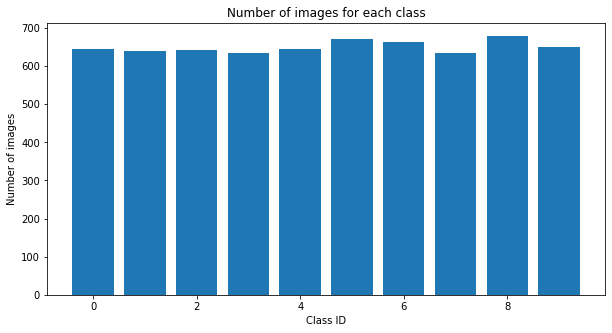

In [6]:
_samples = [len(np.where(Y_train == i)[0]) for i in range(__classes)]
print(_samples)

# visualize the data with histogram
plt.figure(figsize=(10, 5))
plt.bar(range(__classes), _samples)
plt.title("Number of images for each class")
plt.xlabel("Class ID")
plt.ylabel("Number of images")
plt.show()

# 3 – Pre-processare i dati

Le immagini non possono essere consegnate direttamente al modello, sarà necessario
processare i dati per prepararli per la rete neurale. Dopo il pre-processing 
la `X_train.shape` passa da `(6502, 32, 32, 3)` a `(6502, 32, 32)`. La rete
neurale necessita un'altra dimensione, dunque `(6502, 32, 32, 1)`.

In [7]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # grayscale
    image = cv2.equalizeHist(image)  # equalize img (distribute lighting evenly)
    image = image / 255  # normalize img (restrict from [0, 255] to [0, 1])

    return image


# preprocess all the images using map() &overwrite arrays
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_validation = np.array(list(map(preprocess, X_validation)))

# add depth to images
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
X_validation = X_validation.reshape(X_validation.shape + (1,))

print(f"X_train.shape: {X_train.shape}")

X_train.shape: (6502, 32, 32, 1)


Ora è necessario modificare le immagini rendendole mosse, spostandole, zoomando
per rendere il dataset più generico

In [8]:
DataGenerator = ImageDataGenerator(
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    zoom_range         = 0.2,
    shear_range        = 0.1,
    rotation_range     = 0.1,
)

DataGenerator.fit(X_train)

Successivamente effettuiamo il One-Hot encoding delle matrici

In [9]:
Y_train = to_categorical(Y_train, __classes)
Y_test = to_categorical(Y_test, __classes)
Y_validation = to_categorical(Y_validation, __classes)

# 4 – Creare il modello

Creiamo ora il modello per la CNN. Questa generalmente consiste di convolutional
e pooling layers. Funziona meglio per dati rappresentati da strutture a griglia, 
per questo funziona bene per la classificazione delle immagini.

Il layer di dropout è utilizzato per disattivare alcuni neuroni riducendo
l'over fitting del modello.

In [10]:
def get_model(
    filters_num: int,
    filter1: tuple, filter2: tuple,
    input_shape: tuple,
    pool_size: tuple,
    nodes_num: int):

    # generate model
    model = Sequential()
    
    # add convolutional layers (×2)
    model.add(
        Conv2D(
            filters_num,
            filter1,
            input_shape=(input_shape + (1,)),
            activation = "relu"
        )
    )
    model.add(Conv2D(filters_num, filter1, activation="relu"))
    
    # add pooling layer
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # add two more convolutional layers with filter2 and less filters
    model.add(Conv2D(filters_num // 2, filter2, activation="relu"))
    model.add(Conv2D(filters_num // 2, filter2, activation="relu"))
    
    # add additional pooling layer
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # add dropout layer at 50%
    model.add(Dropout(0.5))
    
    # add flatten layer
    model.add(Flatten())
    
    # add dense (×2) + dropout layers
    model.add(Dense(nodes_num, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(__classes, activation="softmax"))
    
    # compile model
    model.compile(
        Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

Assegniamo il modello e otteniamo il sommario

In [11]:
model = get_model(FILTERS, FILTER2, FILTER2, IMG_DIMS, POOL_SIZE, NODES)
csv_logger = CSVLogger("../source/model.csv")
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 60)        600       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 60)        32460     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 30)         0         
 2D)                                                    

# 5 – Addestra il modello

La funzione `model.fit()` di `keras` inizierà il training.

In [12]:
# train the model
history = model.fit(
    DataGenerator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch = STEPS,
    epochs          = EPOCHS,
    validation_data = (X_validation, Y_validation),
    shuffle         = 1,
    callbacks       = [csv_logger]
)

Epoch 1/15
131/131 [==============================] - 6s 22ms/step - loss: 1.1974 - accuracy: 0.5803 - val_loss: 0.1350 - val_accuracy: 0.9569
Epoch 2/15
131/131 [==============================] - 2s 18ms/step - loss: 0.3873 - accuracy: 0.8748 - val_loss: 0.0931 - val_accuracy: 0.9699
Epoch 3/15
131/131 [==============================] - 2s 18ms/step - loss: 0.2514 - accuracy: 0.9180 - val_loss: 0.0485 - val_accuracy: 0.9828
Epoch 4/15
131/131 [==============================] - 2s 18ms/step - loss: 0.1998 - accuracy: 0.9388 - val_loss: 0.0412 - val_accuracy: 0.9883
Epoch 5/15
131/131 [==============================] - 2s 18ms/step - loss: 0.1610 - accuracy: 0.9503 - val_loss: 0.0304 - val_accuracy: 0.9883
Epoch 6/15
131/131 [==============================] - 2s 18ms/step - loss: 0.1376 - accuracy: 0.9556 - val_loss: 0.0447 - val_accuracy: 0.9852
Epoch 7/15
131/131 [==============================] - 2s 18ms/step - loss: 0.1182 - accuracy: 0.9651 - val_loss: 0.0234 - val_accuracy: 0.9902

Mostriamo i dati ottenuti dal training

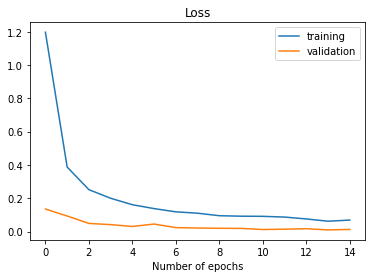

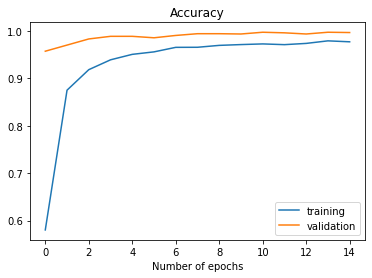

In [13]:
plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Number of epochs")
plt.show()

plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["training", "validation"])
plt.title("Accuracy")
plt.xlabel("Number of epochs")

plt.show()

Controlliamo l'accuratezza del modello

In [14]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(f"Score: {score[0]}\nAccuracy: {score[1]}")

Score: 0.020169300958514214
Accuracy: 0.9936023354530334


Salviamo il modello

In [15]:
model.save("../source/trained_model")

INFO:tensorflow:Assets written to: ../source/trained_model\assets


INFO:tensorflow:Assets written to: ../source/trained_model\assets
